 <h2 style="font-size: 24px;">Dogecoin Price Prediction</h2> By Jodabeni Dondeli  
 
<h2 style="font-size: 20px;">Objective : </h2> 
 The goal of this project is to develop a model that predicts future <b> Closing price</b> movements based on past data, which includes using historical closing prices to forecast the next day's closing price.  
 
 We will leverage the power of XGBoost, a gradient boosting algorithm built on decision trees, which has been proven to enhance prediction performance by effectively handling complex relationships in financial data.
 

 <p style="font-size: 18px;">Load Dogecoin Data</p> For this Model we will be using Kaggle to obtain our Dogecoin Historical Data from 2017 to 11/15/2024 price data.  
 
 
 


In [109]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Load Dogecoin Historical Data
path = kagglehub.dataset_download("lycheezz/historical-data-for-dogeusd-from-2017-to-present")
dogecoin_csv = os.path.join(path, 'Dogecoin-USD Historical Data.csv')
doge_data = pd.read_csv(dogecoin_csv)

# Inspect the dataset
print(doge_data.head())
print(doge_data.info())
print(doge_data.describe())

         Date     Price      Open      High       Low    Vol. Change %
0  11/15/2024  0.369074  0.362314  0.376090  0.354030   9.89B    1.89%
1  11/14/2024  0.362221  0.399322  0.414568  0.353583   9.35B   -9.29%
2  11/13/2024  0.399327  0.379912  0.430831  0.355127  16.78B    5.10%
3  11/12/2024  0.379953  0.350381  0.436869  0.330961  22.95B    8.45%
4  11/11/2024  0.350360  0.277409  0.350360  0.274043  14.68B   26.24%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2723 entries, 0 to 2722
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2723 non-null   object 
 1   Price     2723 non-null   float64
 2   Open      2723 non-null   float64
 3   High      2723 non-null   float64
 4   Low       2723 non-null   float64
 5   Vol.      2722 non-null   object 
 6   Change %  2723 non-null   object 
dtypes: float64(4), object(3)
memory usage: 149.0+ KB
None
             Price         Open         High          Low


 <p style="font-size: 18px;">Dogecoin Data Preprocessing</p>  Now that we have the data loaded, we want to Find all the missing values, covert date column and Add time features.  
   
 "Price" Column is the Closing Price of Dogecoin
 

In [110]:
# Preprocessing Function
def preprocess_data(df): # Creating Function preprocess_data
    # Drop rows with missing values
    df.dropna(inplace=True)
    # Convert Date column to datetime and sort by date
    df['Date'] = pd.to_datetime(df['Date'])  #11/15/2024 allow us to process this format of Date
    df.sort_values('Date', inplace=True)
    
    # Create time-based features
    df['DayOfWeek'] = df['Date'].dt.dayofweek #Sort Dates in weeks
    df['Month'] = df['Date'].dt.month #sort Dates in Months
    
    # Calculate 10-day moving average
    df['MA_10'] = df['Price'].rolling(window=10).mean()
    
    # Clean Change % column , so it can become a float
    df['Change %'] = (
        df['Change %']
        .str.replace(',', '')
        .str.replace('%', '')
        .fillna('0')
        .astype(float) / 100
    )
    
    # Clean Vol. column and handle unit conversions
    df['Vol.'] = (
        df['Vol.']
        .str.replace(',', '')
        .apply(lambda x: float(x.replace('B', '')) * 1e9 if 'B' in x else
                      float(x.replace('M', '')) * 1e6 if 'M' in x else float(x))
    )
    
    # Create lagged features
    df['Price_Lag_1'] = df['Price'].shift(1)
    df['Price_Lag_7'] = df['Price'].shift(7)
    
    return df

Apply preprocessing

In [111]:
# Apply preprocessing
doge_data = preprocess_data(doge_data)

<p style="font-size: 18px;">Train-Test Split:</p>   
Split the data into training and testing sets based on dates to avoid data leakage  

The dataset starts on **06/03/2017** and ends on **11/15/2024** (total of **2,722 days**).   
 

**Training Set:**  
**80% of 2,722 days ≈ 2,178 days**.  
Training End Date = 06/03/2017 + 2,178 days = 05/15/2023.  
*20% Test Set:  

Test Start Date = 05/15/2023.  
Test End Date = 11/15/2024. 



In [112]:
# Split the data into train and test sets
train_data = doge_data[doge_data['Date'] < '2023-05-15']
test_data = doge_data[doge_data['Date'] >= '2023-05-15']

Defining the independent variables Features and dependent the <b>target Price

In [113]:
#  defining the independent variables Features and dependent the target Price
features = ['Price', 'Change %', 'Vol.', 'MA_10', 'Price_Lag_1', 'Price_Lag_7', 'DayOfWeek', 'Month']

X_train = train_data[features] # extracts the input features
y_train = train_data['Price'] # extracts the target variable

X_test = test_data[features] #extract the input features from the test dataset
y_test = test_data['Price']#extracts the actual prices (target variable) from the test dataset

<p style="font-size: 18px;">Scale the data:</p>  
 To avoid mistakes with large ranges of numbers. Scaling ensures that the model treats all features equall

In [114]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



 <p style="font-size: 18px;">Check the CSV data Plot</p>   

Plotting the Results to Confirm the data matches Dogecoin on Coinmarketcap

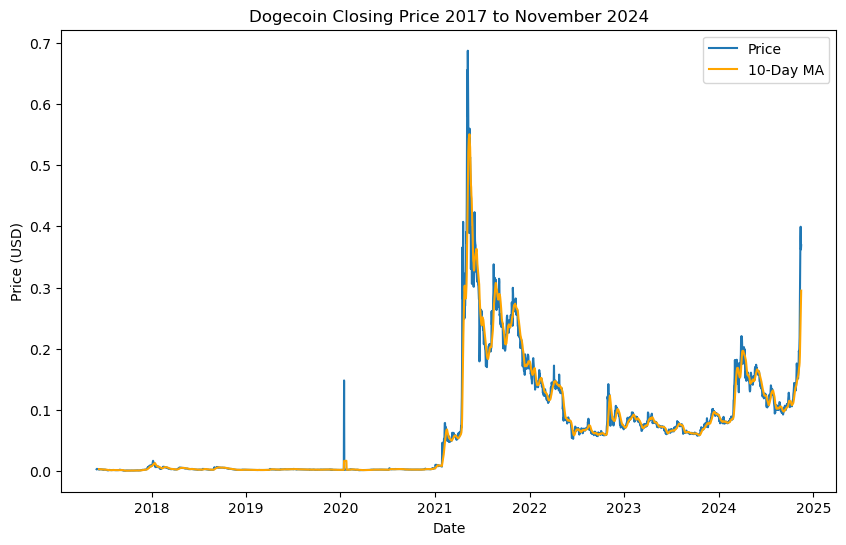

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(doge_data['Date'], doge_data['Price'], label='Price')
plt.plot(doge_data['Date'], doge_data['MA_10'], label='10-Day MA', color='orange')
plt.legend()
plt.title('Dogecoin Closing Price 2017 to November 2024')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()


<p style="font-size: 18px;">Initialize and train the XGBoost model</p>  
 XGBoost with Technical Indicators  
 
 XGBoost Python Package is required for code to run.   
 
 Pros: Powerful and Robust (technical indicators, historical prices) and is less likely to overfit.



In [116]:
# Initialize and train the XGBoost model
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, verbosity=0)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

  <p style="font-size: 20px;">Predict and evaluate</p>  

Mean Absolute Error (MAE):
Definition: MAE measures the average magnitude of errors between predicted values and actual values, without considering their direction (positive or negative).  

Mean Squared Error (MSE):
Definition: MSE calculates the average of the squared differences between predicted values and actual values. Squaring the differences makes MSE more sensitive to large errors.  

Root Mean Squared Error (RMSE):
Definition: RMSE is the square root of the MSE. It brings the error back to the original scale of the target variable, which makes it easier to interpret.

In [117]:
# Predict and evaluate
def evaluate_model(model, X, y):
    y_pred = model.predict(X) # Predict the target variable (price) for the given input
    mae = mean_absolute_error(y, y_pred) # Calculate the Mean Absolute Error (MAE) between the true values (y) and predicted values (y_pred)
    mse = mean_squared_error(y, y_pred) # Calculate the Mean Squared Error (MSE), which penalizes larger errors more heavily
    rmse = mse ** 0.5 # Square root of MSE to get RMSE
    return y_pred, mae, mse, rmse

Clean and double check that there isnt any missing values and remove it. Then Print the MAE, MSE, RMSE

In [118]:
# Clean test data and re-validate
test_data_clean = test_data.dropna(subset=features + ['Price'])
X_test_clean = scaler.transform(test_data_clean[features])
y_test_clean = test_data_clean['Price']

# Evaluate on cleaned data
y_pred_clean, mae, mse, rmse = evaluate_model(model, X_test_clean, y_test_clean)

# Print evaluation results
print(f"Mean Absolute Value (MAE): {mae:.4f}, Mean Squared Error (MSE): {mse:.4f}, Root Mean Squared Error (RMSE): {rmse:.4f}")



Mean Absolute Value (MAE): 0.0009, Mean Squared Error (MSE): 0.0000, Root Mean Squared Error (RMSE): 0.0018


<p style="font-size: 18px;">Final Plot  of Actual Closing Price vs Predicted Closing Price


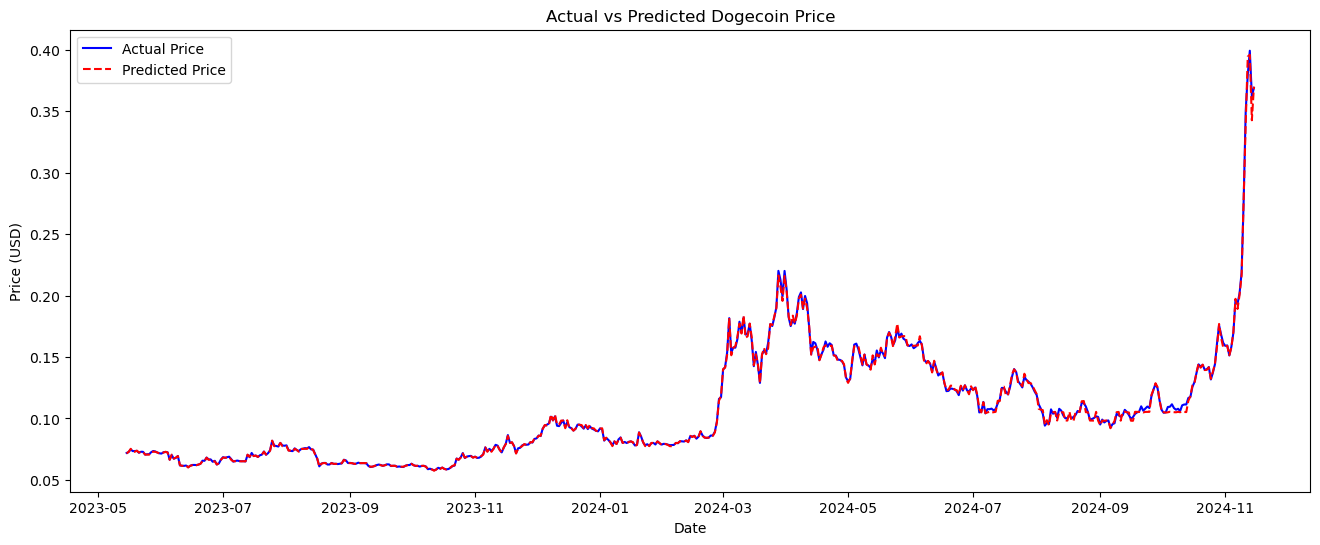

In [119]:
# Plotting
plt.figure(figsize=(16, 6))
plt.plot(test_data_clean['Date'], y_test_clean, label='Actual Price', color='blue')
plt.plot(test_data_clean['Date'], y_pred_clean, label='Predicted Price', color='red', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Dogecoin Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()